In [59]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import skimage.io as io
import skimage.transform as trans
import torch.nn as nn

# Explore and preprocess datasets
Some of the input cell image having 3 or 4 channels, which is unnessary for segmentation, we need to transfer to grayscale.

Also some masks are having same channel issue, as well as, numerical difference on different images. Some image's pixel range from 0 to 1, some from 0 to 255. We need to normalize them with same scale.

Also some masks have 0 as backgrounds, some may have 1 as backgrounds, we need to unify them. 

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
(27, 256, 256)
1.0 0.0


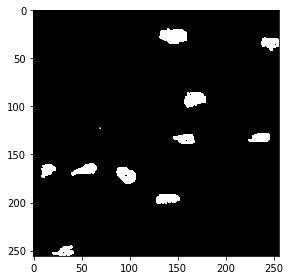

1
1.0 0.0


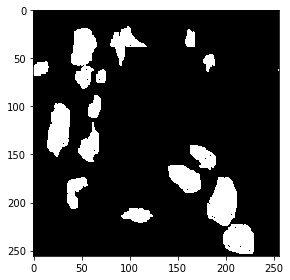

2
1.0 0.0


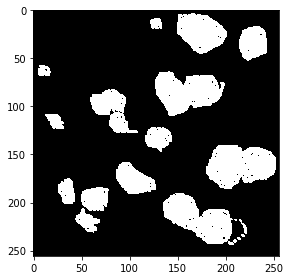

3
1.0 0.0


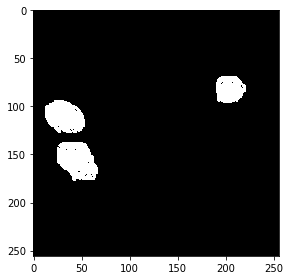

4
1.0 0.0


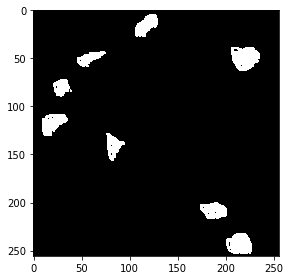

5
1.0 0.0


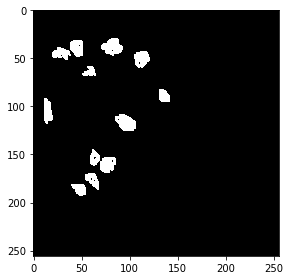

6
1.0 0.0


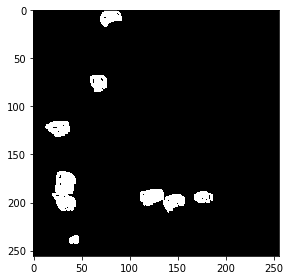

7
0.2125 0.0


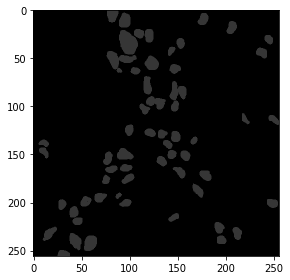

8
0.2125 0.0


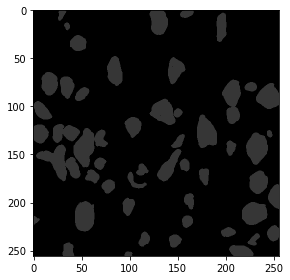

9
0.2125 0.0


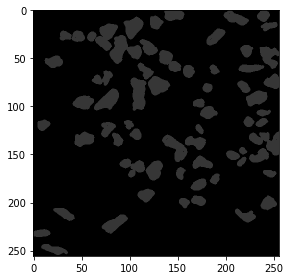

10
0.2125 0.0


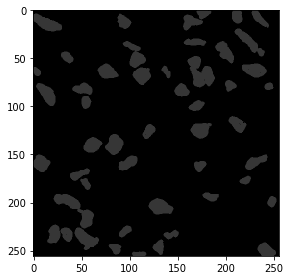

11
0.2125 0.0


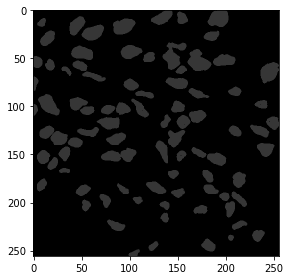

12
0.2125 0.0


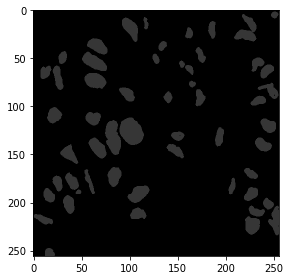

13
1.0 0.0


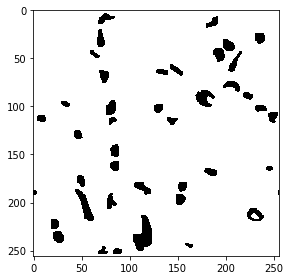

14
1.0 0.0


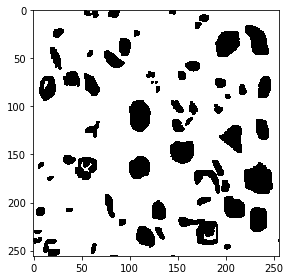

15
1.0 0.0


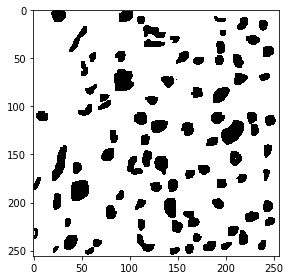

16
1.0 0.0


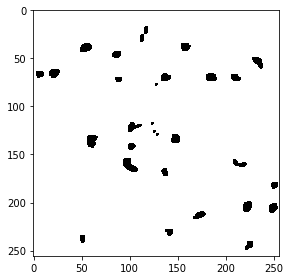

17
1.0 0.0


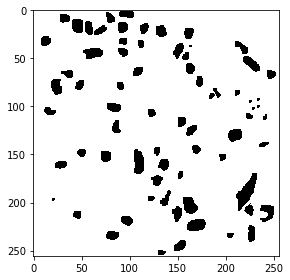

18
1.0 0.0


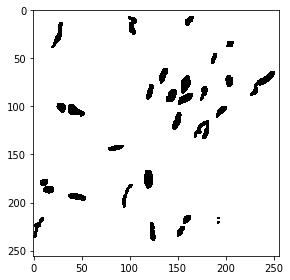

19
1.0 0.0


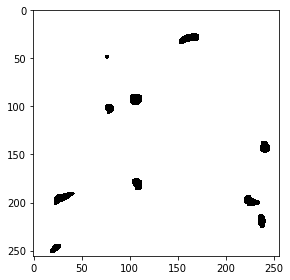

20
1.0 0.0


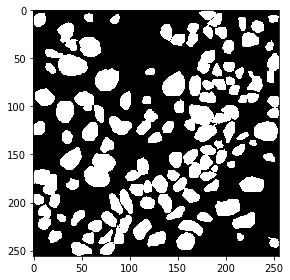

21
1.0 0.0


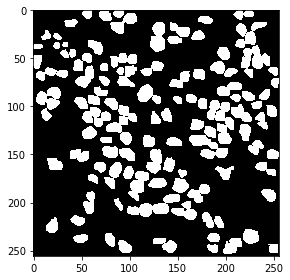

22
1.0 0.0


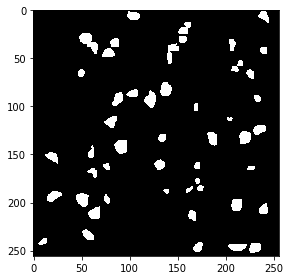

23
1.0 0.0


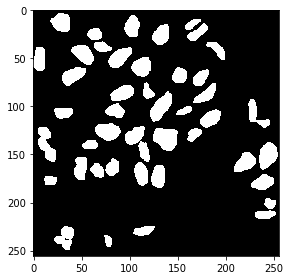

24
1.0 0.0


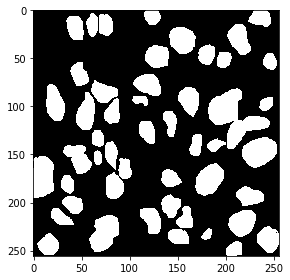

25
1.0 0.0


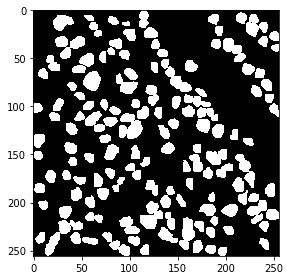

26
1.0 0.0


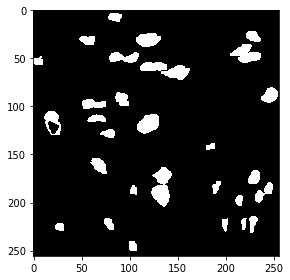

27
1.0 0.0


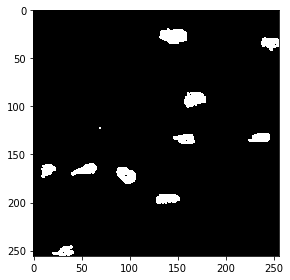

1
1.0 0.0


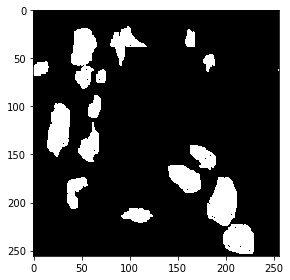

2
1.0 0.0


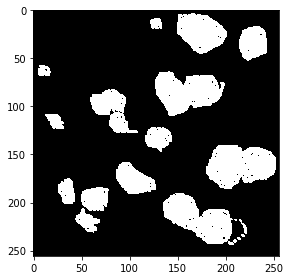

3
1.0 0.0


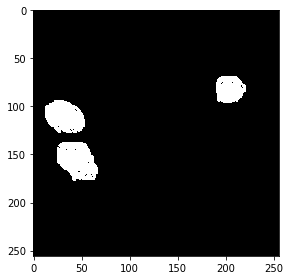

4
1.0 0.0


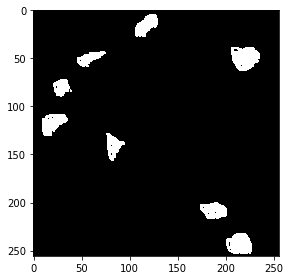

5
1.0 0.0


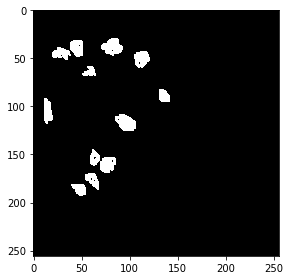

6
1.0 0.0


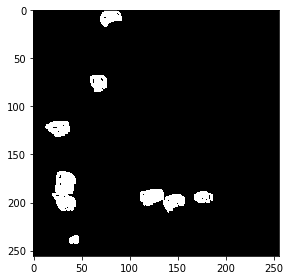

7
1.0 0.0


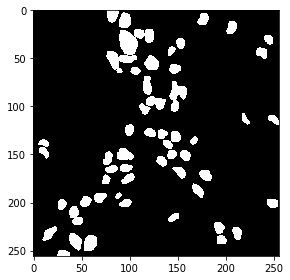

8
1.0 0.0


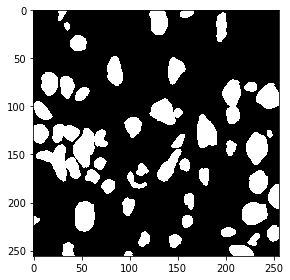

9
1.0 0.0


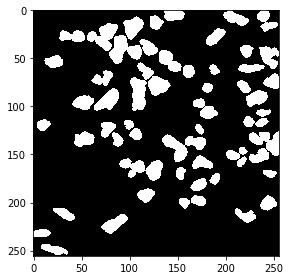

10
1.0 0.0


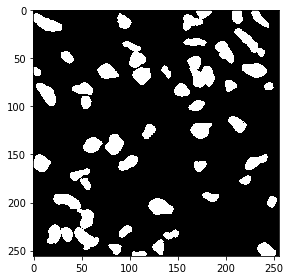

11
1.0 0.0


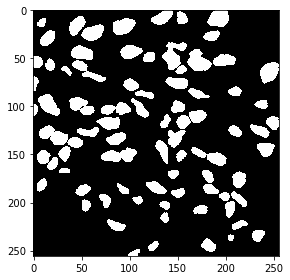

12
1.0 0.0


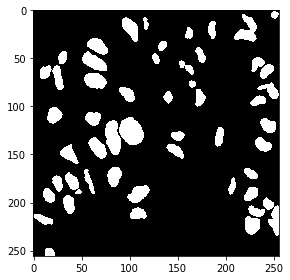

13
1.0 0.0


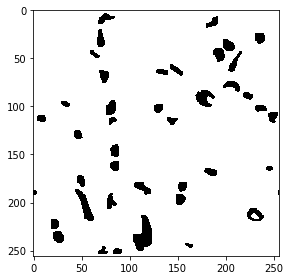

14
1.0 0.0


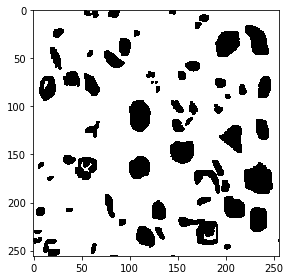

15
1.0 0.0


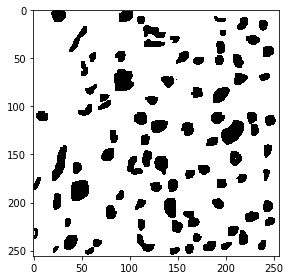

16
1.0 0.0


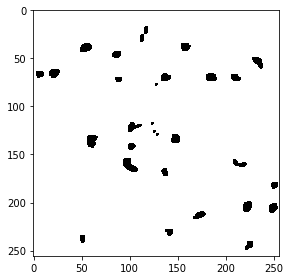

17
1.0 0.0


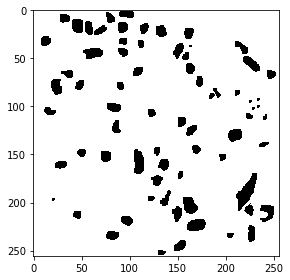

18
1.0 0.0


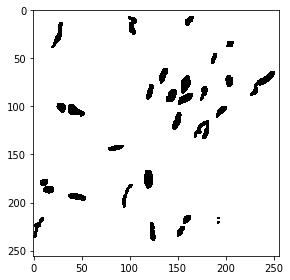

19
1.0 0.0


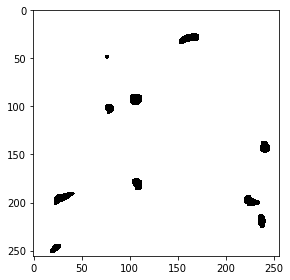

20
1.0 0.0


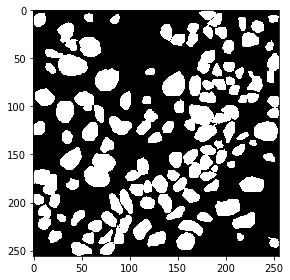

21
1.0 0.0


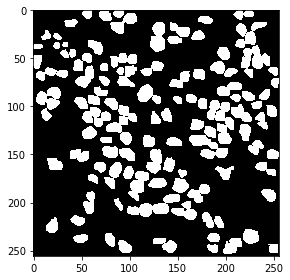

22
1.0 0.0


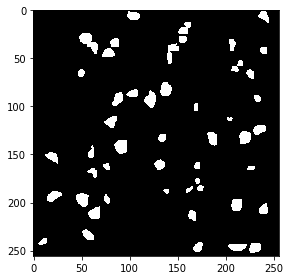

23
1.0 0.0


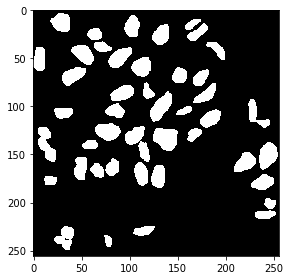

24
1.0 0.0


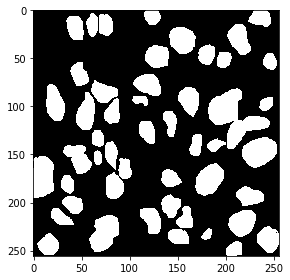

25
1.0 0.0


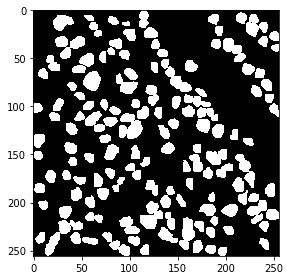

26
1.0 0.0


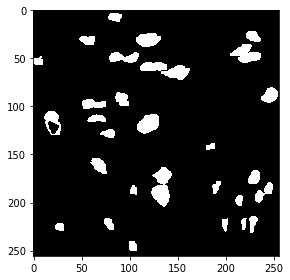

27
1.0 0.0


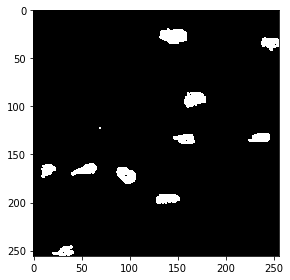

1
1.0 0.0


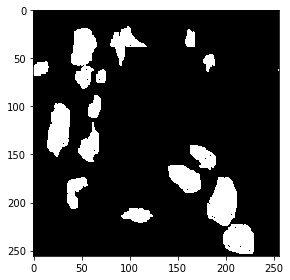

2
1.0 0.0


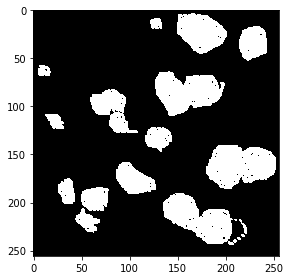

3
1.0 0.0


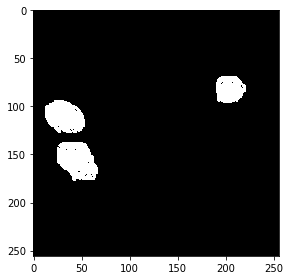

4
1.0 0.0


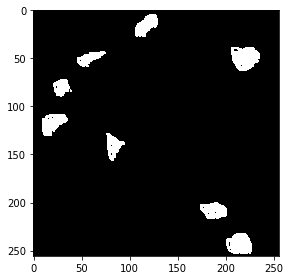

5
1.0 0.0


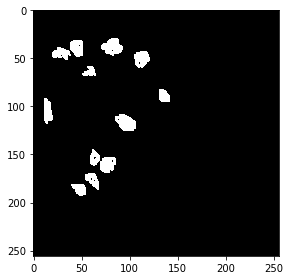

6
1.0 0.0


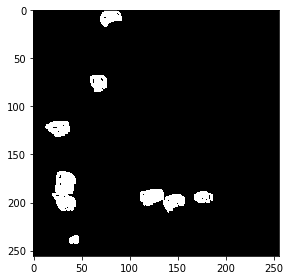

7
1.0 0.0


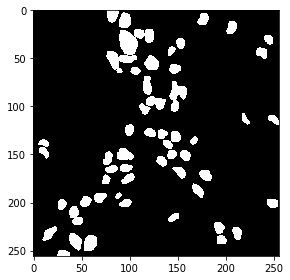

8
1.0 0.0


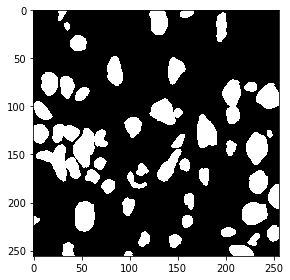

9
1.0 0.0


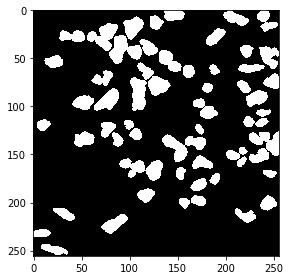

10
1.0 0.0


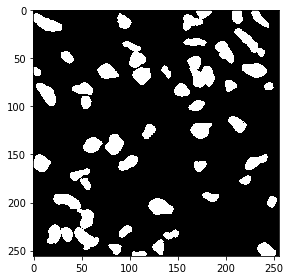

11
1.0 0.0


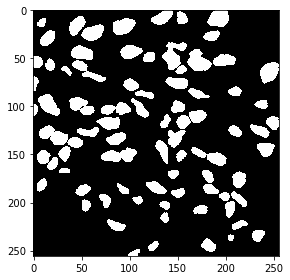

12
1.0 0.0


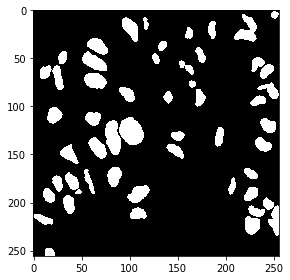

13
1.0 0.0


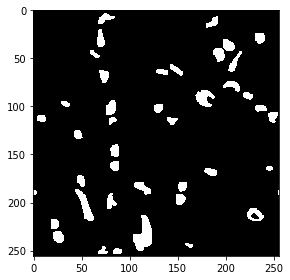

14
1.0 0.0


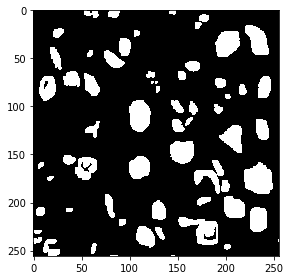

15
1.0 0.0


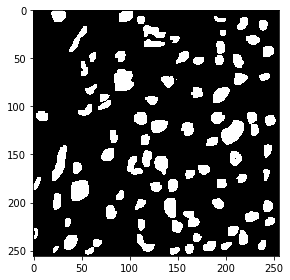

16
1.0 0.0


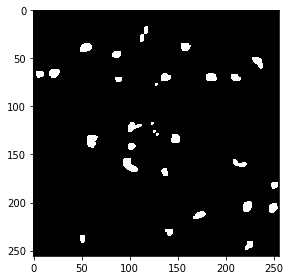

17
1.0 0.0


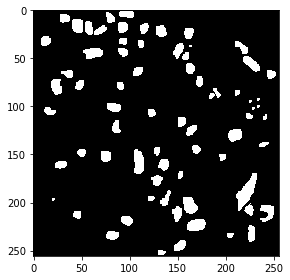

18
1.0 0.0


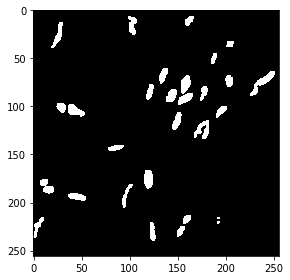

19
1.0 0.0


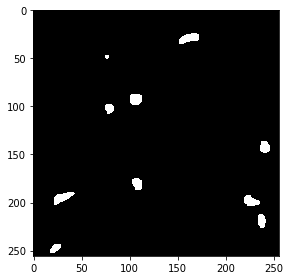

20
1.0 0.0


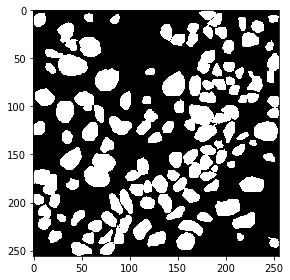

21
1.0 0.0


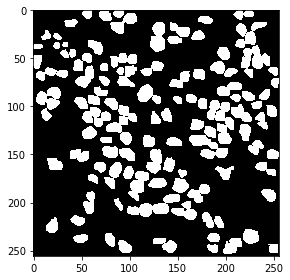

22
1.0 0.0


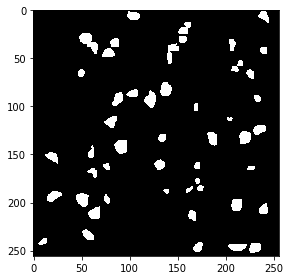

23
1.0 0.0


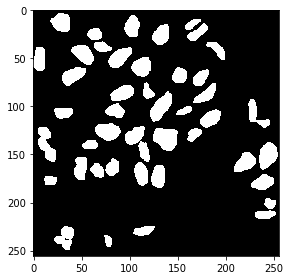

24
1.0 0.0


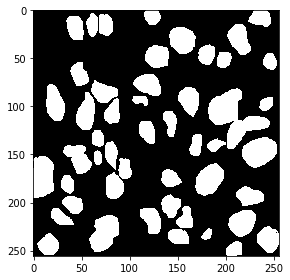

25
1.0 0.0


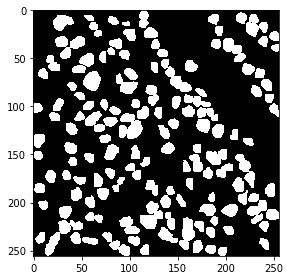

26
1.0 0.0


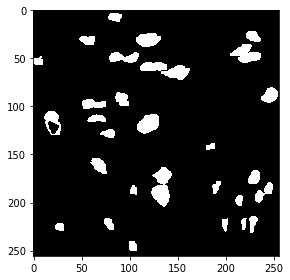

27
(27, 256, 256)


In [61]:
#clean and manipulate data
import skimage
from skimage.io import *
from skimage.color import *
from skimage.filters import threshold_otsu
rang = [i for i in range(1,28)]
print(rang)
#im.show()
def read_img(img_dir):
    imgs = []
    for i in rang:
        img_ = img_dir + 'patch' + str(i) + '.tif'
        try:
            imgs.append(imread(img_))
        except:
            img_ = img_dir + 'patch' + str(i) + '.tiff'
            imgs.append(imread(img_))
            
    return imgs


def read_mask(mask_dir):
    imgs = []
    print(rang)
    for i in rang:
        img_ = mask_dir + 'mask' + str(i) + '.tif'
        try:
            imgs.append(imread(img_))
        except:
            img_ = mask_dir + 'mask' + str(i) + '.tiff'
            imgs.append(imread(img_))
        
    return imgs

org_imgs = read_img('cell_data/')
mask_imgs = read_mask('cell_data/')

def normalize(x):
    a = x.shape
    x.reshape(-1,1)
    #print(x.shape)
    x = (x - x.mean())/x.std()
    x.reshape(a)
    return x

#transfer from rgb with 3 or 4 channels to grayscale
org_imgs = [rgb2gray(i) for i in org_imgs]
org_imgs = [normalize(i) for i in org_imgs]
org_imgs = np.asarray(org_imgs)
np.save('cell_data/org_imgs.npy',org_imgs )
print(org_imgs.shape)

def print_img(imgs):
    j = 0
    for i in imgs:
        print(np.max(i), np.min(i))
        j += 1
        imshow(i)
        plt.show()
        print(j)
def binary(imgs):
    result = []
    for i in imgs:
        #print(np.max(i), np.min(i))
        thresh = threshold_otsu(i)
        binary = i > thresh
        result.append(binary)
    return result

mask_imgs = [rgb2gray(i) for i in mask_imgs]
#mask_imgs = [np.asarray(binary(i)) for i in mask_imgs]
#mask_imgs = [normalize(i) for i in mask_imgs]

mask_imgs = np.asarray(mask_imgs)
print_img(mask_imgs)

mask_imgs[mask_imgs > 0] = 1
print_img(mask_imgs)

#flip none zero backgrounds to zeros
k = np.zeros(mask_imgs.shape)
ones = np.ones(mask_imgs[0].shape)
for i in range(mask_imgs.shape[0]):
    if i >12 and i <20:
        k[i] = ones - mask_imgs[i]
    else:
        k[i] = mask_imgs[i]
        
print_img(k)
np.save('cell_data/mask_imgs.npy', k)

mask_imgs = np.load('cell_data/mask_imgs.npy')
print(mask_imgs.shape)


In [2]:
#utilities for unet
class conv_twice(nn.Module):
    #two conv  sequential model#
    def __init__(self, in_channels, out_channels):
        super(conv_twice, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    def forward(self, x):
        x  = self.conv(x)
        return x

class input_conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(input_conv, self).__init__()
        self.conv = conv_twice.conv(in_channels,out_channels)
    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(down, self).__init__()
        self.maxpooling_conv = nn.Sequential(
            nn.MaxPool2d(2),
            conv_twice(in_channels,out_channels)
        )
    def forward(self,x):
        x = self.maxpooling_conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_channels, out_channels, ups = False):
        super(up,self).__init__()
        
        if ups:
            self.up = nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True)
            
        else:
            self.up = nn.ConvTranspose2d(in_channels//2, in_channels, 2, stride = 2)
        self.conv = conv_twice(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffx = x1.size()[2] - x2.size()[2]
        diffy = x1.size()[2] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2), diffY // 2, int(diffY / 2)))
        x = torch.cat([x2,x1], dim = 1)
        x.self.conv(x)
        return x
                    
class out_conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(out_conv, self).__init__()
        self.conv  = nn.Conv2d(in_channels,out_channels,1)
    
    def forwad(self, x):
        x = self.conv(x)
        return x

In [3]:
#build Unet structure
class Unet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        #self.down4 = down(512, 512)
        #self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        #x5 = self.down4(x4)
        #x = self.up1(x5, x4)
        x = self.up2(x4, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [26]:
#train process
import sys
import os
from optparse import OptionParser
import numpy as np

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 1
batch_size = 10
learning_rate = 0.001




model = Unet(n_channels, n_classes).to(device)

# Loss and optimizer binary cross entropy
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')


NameError: name 'n_channels' is not defined

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
(27, 256, 256)
1.0 0.0


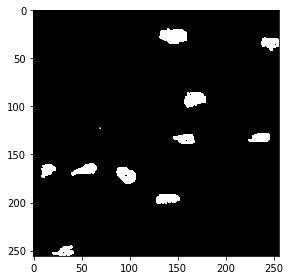

1
1.0 0.0


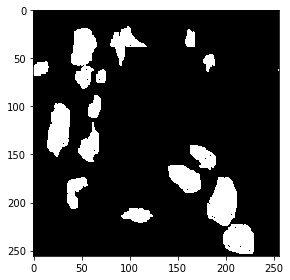

2
1.0 0.0


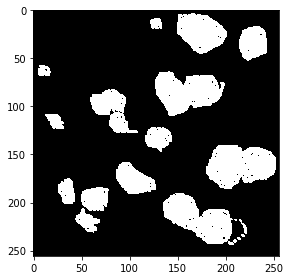

3
1.0 0.0


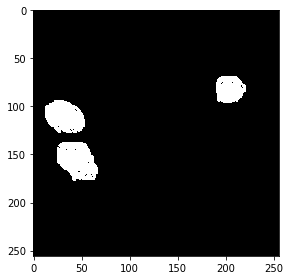

4
1.0 0.0


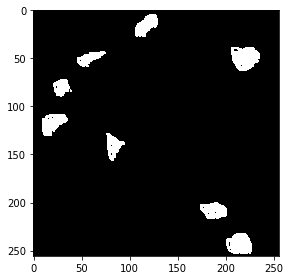

5
1.0 0.0


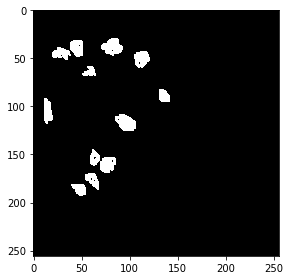

6
1.0 0.0


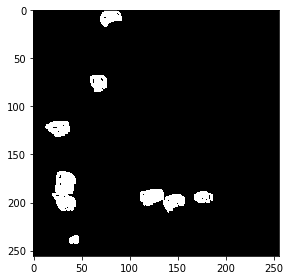

7
0.2125 0.0


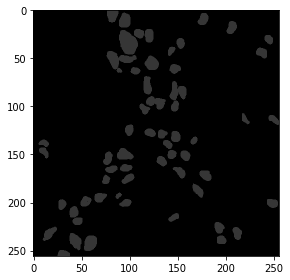

8
0.2125 0.0


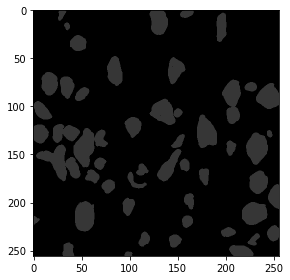

9
0.2125 0.0


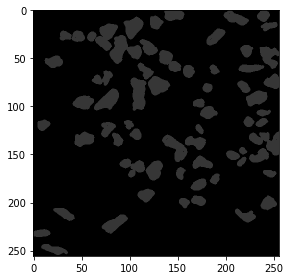

10
0.2125 0.0


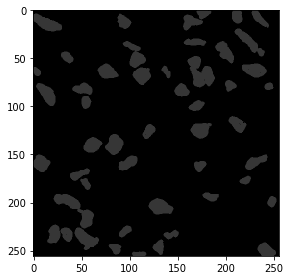

11
0.2125 0.0


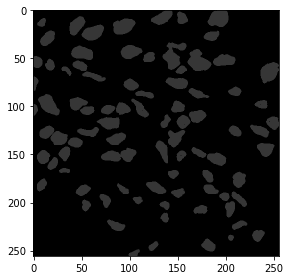

12
0.2125 0.0


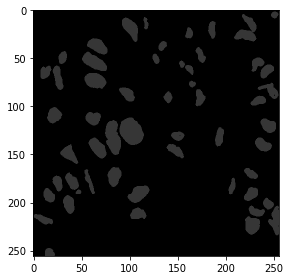

13
1.0 0.0


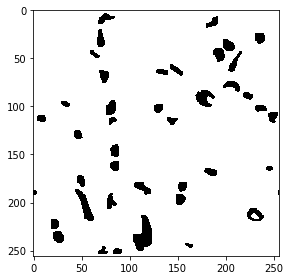

14
1.0 0.0


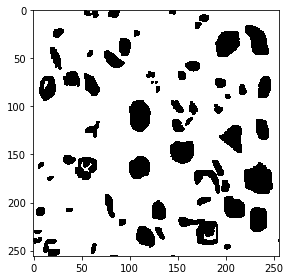

15
1.0 0.0


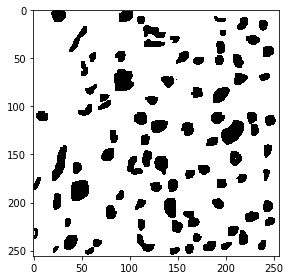

16
1.0 0.0


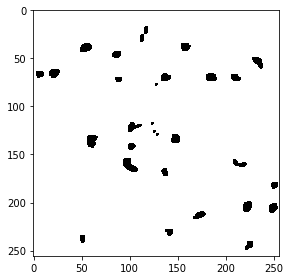

17
1.0 0.0


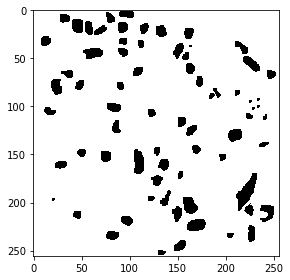

18
1.0 0.0


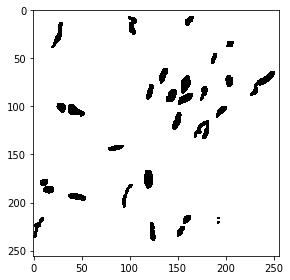

19
1.0 0.0


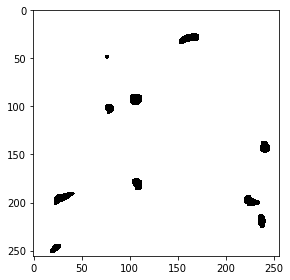

20
1.0 0.0


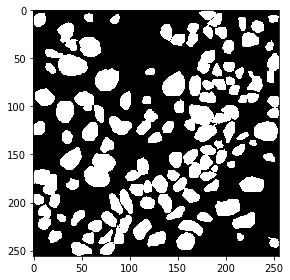

21
1.0 0.0


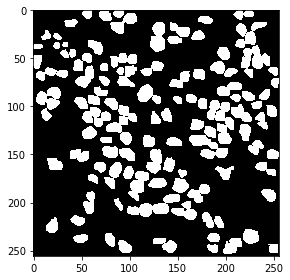

22
1.0 0.0


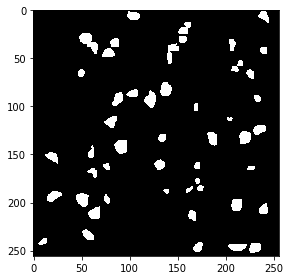

23
1.0 0.0


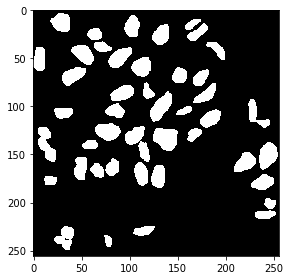

24
1.0 0.0


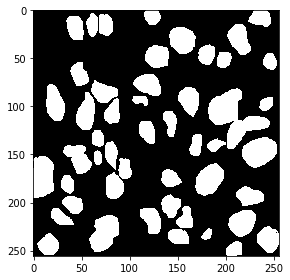

25
1.0 0.0


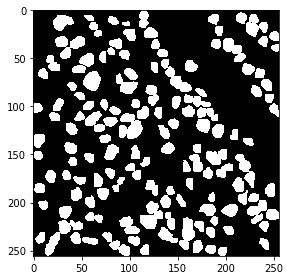

26
1.0 0.0


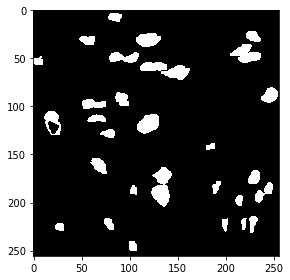

27
1.0 0.0


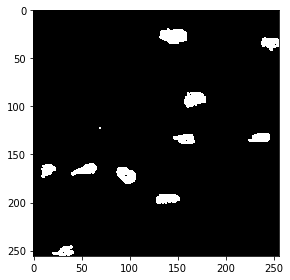

1
1.0 0.0


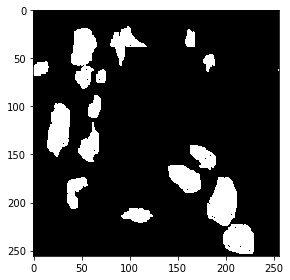

2
1.0 0.0


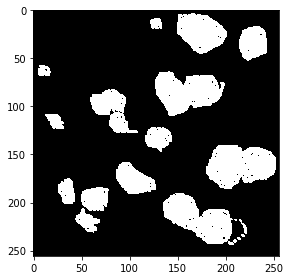

3
1.0 0.0


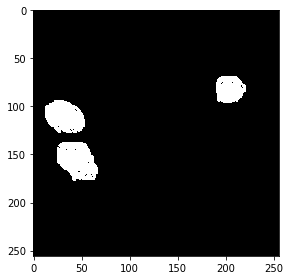

4
1.0 0.0


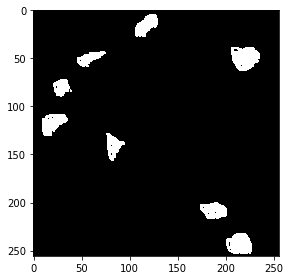

5
1.0 0.0


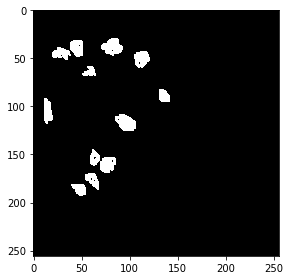

6
1.0 0.0


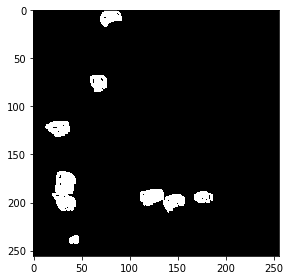

7
1.0 0.0


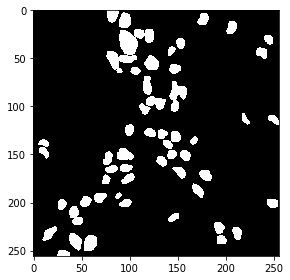

8
1.0 0.0


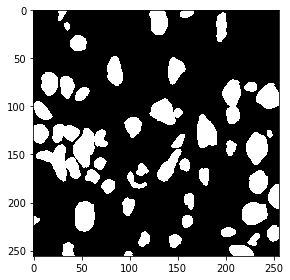

9
1.0 0.0


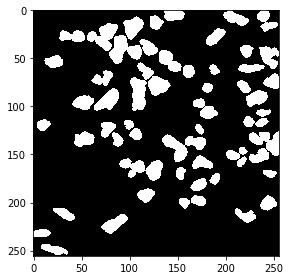

10
1.0 0.0


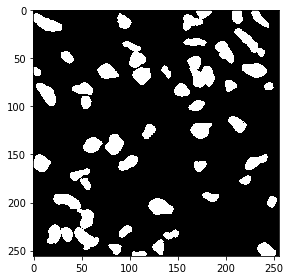

11
1.0 0.0


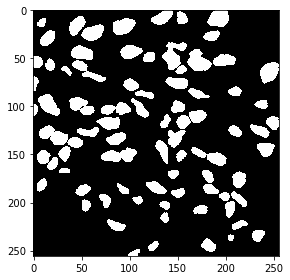

12
1.0 0.0


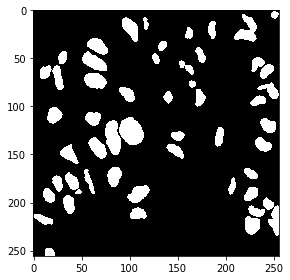

13
1.0 0.0


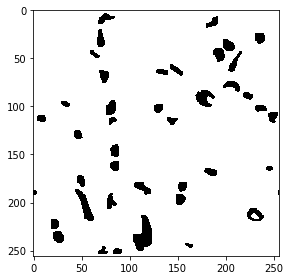

14
1.0 0.0


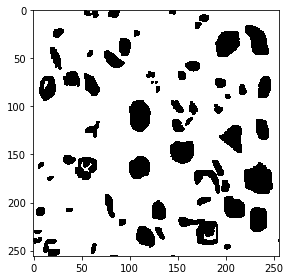

15
1.0 0.0


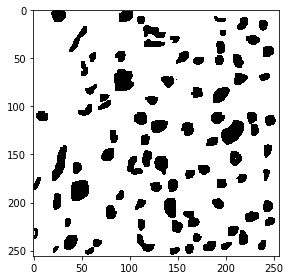

16
1.0 0.0


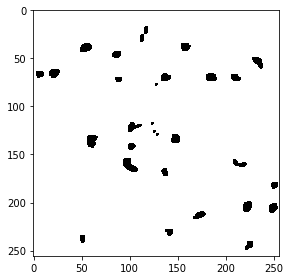

17
1.0 0.0


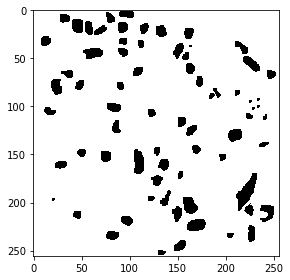

18
1.0 0.0


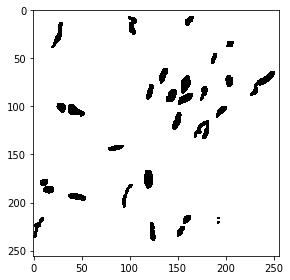

19
1.0 0.0


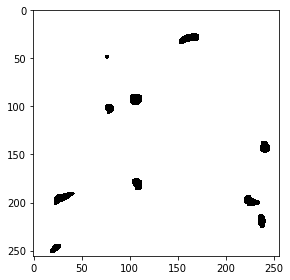

20
1.0 0.0


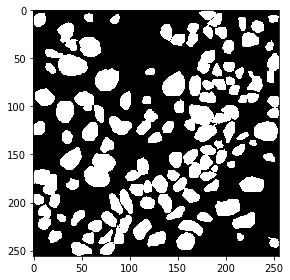

21
1.0 0.0


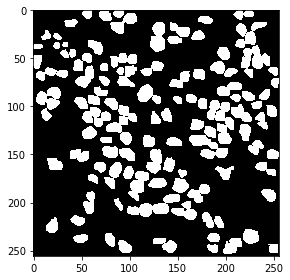

22
1.0 0.0


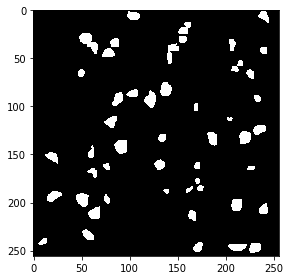

23
1.0 0.0


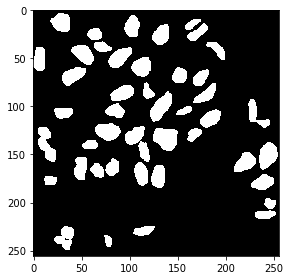

24
1.0 0.0


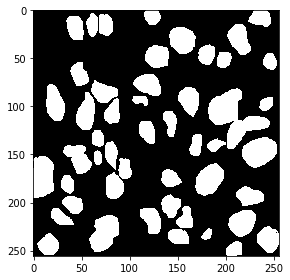

25
1.0 0.0


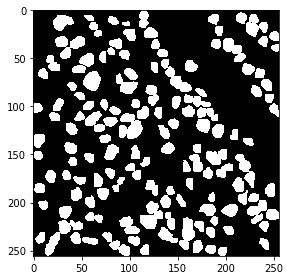

26
1.0 0.0


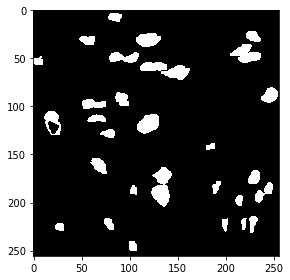

27
1.0 0.0


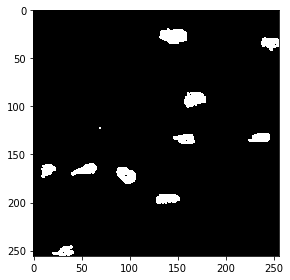

1
1.0 0.0


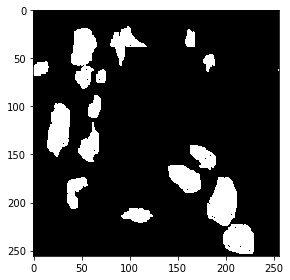

2
1.0 0.0


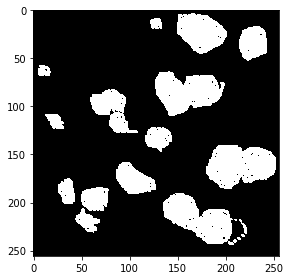

3
1.0 0.0


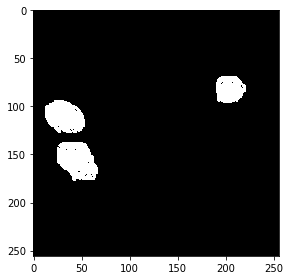

4
1.0 0.0


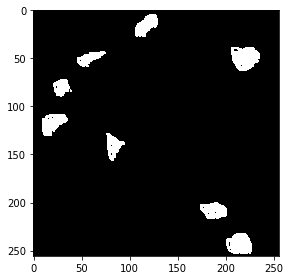

5
1.0 0.0


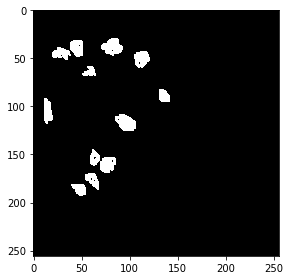

6
1.0 0.0


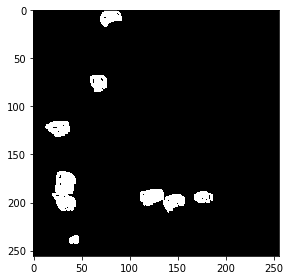

7
1.0 0.0


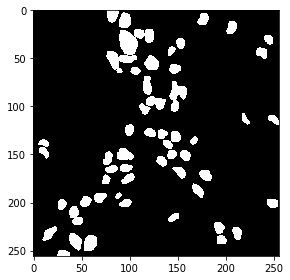

8
1.0 0.0


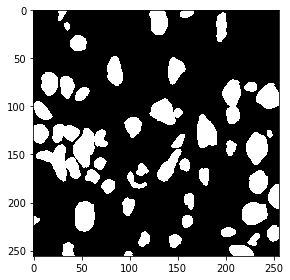

9
1.0 0.0


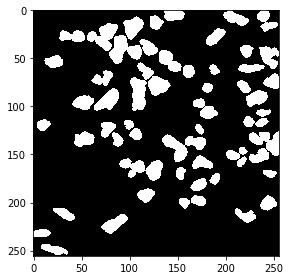

10
1.0 0.0


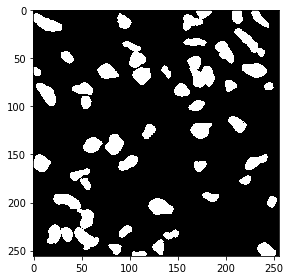

11
1.0 0.0


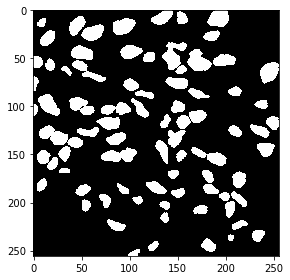

12
1.0 0.0


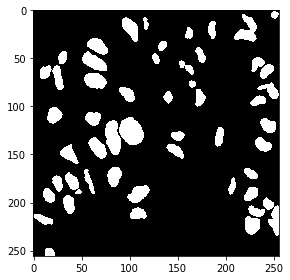

13
1.0 0.0


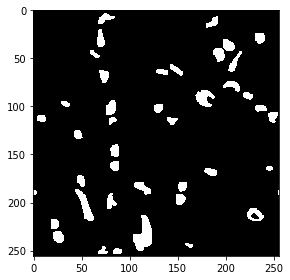

14
1.0 0.0


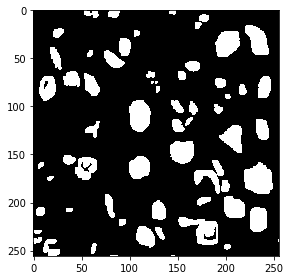

15
1.0 0.0


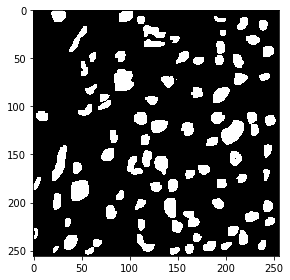

16
1.0 0.0


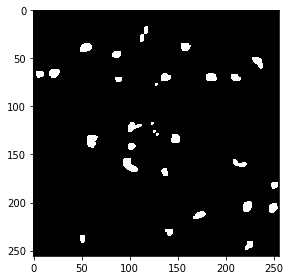

17
1.0 0.0


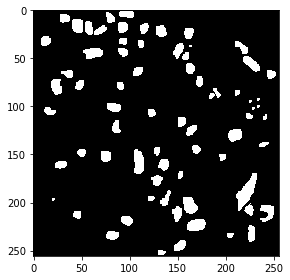

18
1.0 0.0


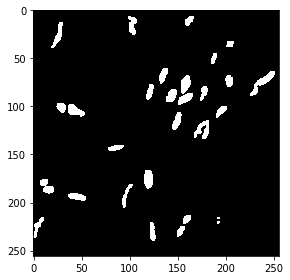

19
1.0 0.0


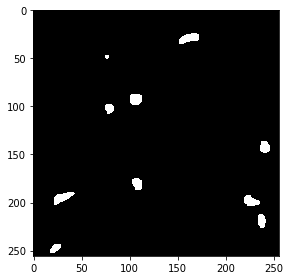

20
1.0 0.0


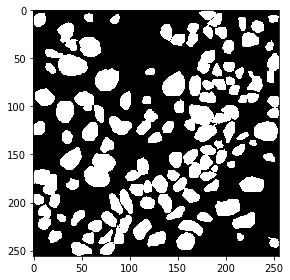

21
1.0 0.0


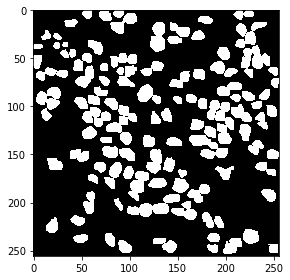

22
1.0 0.0


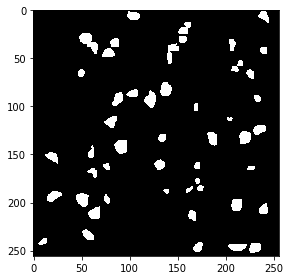

23
1.0 0.0


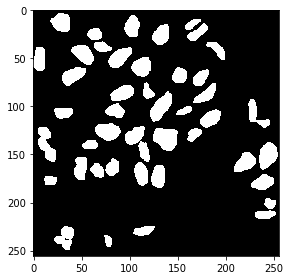

24
1.0 0.0


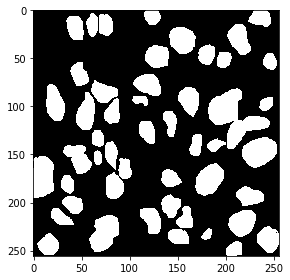

25
1.0 0.0


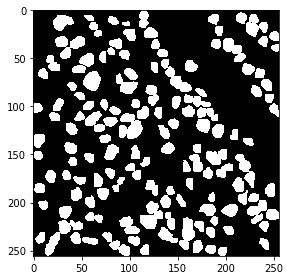

26
1.0 0.0


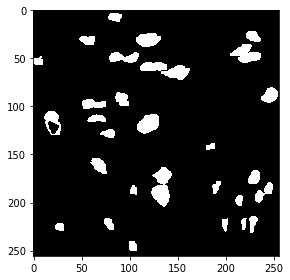

27
(27, 256, 256)
